<a href="https://colab.research.google.com/github/pratham-gupta/SkimLit_Implementation/blob/master/SkimLit_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: SkimList
The purpose of the notbook is to build multiple NLP model to make reading abstracts easier.
The Dataset comprises the abstracts of medical research paper divided into multiple categories such as background,methods, objectives, conclusions...
The goal of the notebook is to classify the categorise the given paragraph of an abstract, which hence helps the reader in understanding the text.

Dataset: PubMed 200k RCT https://arxiv.org/abs/1710.06071 <br>
https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
#confirm the GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e5086c98-89e9-2fc4-fc5c-9d55b88fbbc6)


In [2]:
#get the data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls  pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 1 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
!ls /content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


## Visualize and Preprocess
performing the experiments on smaller dataset <br>
Visualizing the dataset and preprocess it

In [4]:
#setting the datadir for smaller dataset
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


#visualizing the data
with open('/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt') as f:
  a = f.readlines()

In [5]:
#looks like each para/line of an abstract is divided into lines and each line is given the given category in starting of it.
#starting of each para is started with `###88888`formated numbers 
print(*a[:16])

###24293578
 OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
 METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
 METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
 METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
 METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
 METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( 

In [6]:
def get_lines(filename):
  """
  Reads a given text file and returns the lines of text as list
  Args:
    filename: a string containing the target filepath (*.txt file)
  Returns:
    A list of string with one string per line from the target filename
  """
  with open(filename) as f:
    return f.readlines()



In [7]:
#reading the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:17]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
#preprocess text
def preprocess_text_with_line_numbers(filename):

  input_lines = get_lines(filename)


  count = 0
  abstract_samples = []
  abstract_lines = ""

  for line in input_lines:
    #check if line contains the line number
    if line.startswith("###"):
      curr_abstract_id = line
      abstract_lines = ""


    elif line.isspace(): #if the line is completely empty, means end of 1 abstract, which we can process.
      
      abstract_lines_split = abstract_lines.splitlines()
      total_abstract_lines = len(abstract_lines_split) - 1
      for line_number, line in enumerate(abstract_lines_split):
        line_data = {}
        sentence_category, sentence = line.split("\t")
        line_data['line_number'] = line_number
        line_data['target'] = sentence_category
        line_data['text'] = sentence
        line_data['total_lines'] = total_abstract_lines
        abstract_samples.append(line_data)

      

        
        


    else:
      abstract_lines += line
        
      
    #print(line)
    # count +=1
    # if count == 20:
    #   break

  return abstract_samples

In [9]:
%%time
import pandas as pd
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")

CPU times: user 516 ms, sys: 111 ms, total: 626 ms
Wall time: 626 ms


In [10]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [11]:
print(train_df.head(5))
print(val_df.head(5))
print(test_df.head(5))

   line_number     target                                               text  \
0            0  OBJECTIVE  To investigate the efficacy of @ weeks of dail...   
1            1    METHODS  A total of @ patients with primary knee OA wer...   
2            2    METHODS  Outcome measures included pain reduction and i...   
3            3    METHODS  Pain was assessed using the visual analog pain...   
4            4    METHODS  Secondary outcome measures included the Wester...   

   total_lines  
0           11  
1           11  
2           11  
3           11  
4           11  
   line_number      target                                               text  \
0            0  BACKGROUND  IgE sensitization to Aspergillus fumigatus and...   
1            1  BACKGROUND  It is not clear whether these patients would b...   
2            2   OBJECTIVE  We sought to determine whether a @-month cours...   
3            3     METHODS  Asthmatic patients who were IgE sensitized to ...   
4           

In [12]:
#distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

In [13]:
# process ahead, process text into numbers via text_vectorization(using tfidf or count_vectorizer), target labels into label encodings.
train_df

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11
...,...,...,...,...
180035,7,RESULTS,For the absolute change in percent atheroma vo...,11
180036,8,RESULTS,"For PAV , a significantly greater percentage o...",11
180037,9,RESULTS,Both strategies had acceptable side effect pro...,11
180038,10,CONCLUSIONS,"Compared with standard statin monotherapy , th...",11


In [14]:
#converting target column to encoded labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

In [15]:
le.fit(train_df['target'])

LabelEncoder()

In [16]:
target_label_map = dict(zip(le.classes_,le.transform(le.classes_)))
label_target_map = dict( [(val,key) for key,val in target_label_map.items()])
print(target_label_map,label_target_map)

{'BACKGROUND': 0, 'CONCLUSIONS': 1, 'METHODS': 2, 'OBJECTIVE': 3, 'RESULTS': 4} {0: 'BACKGROUND', 1: 'CONCLUSIONS', 2: 'METHODS', 3: 'OBJECTIVE', 4: 'RESULTS'}


In [17]:
num_classes = len(le.classes_)
class_names = le.classes_
print(class_names)

['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


In [18]:
train_labels_encoded = le.transform(train_df['target'])
test_labels_encoded = le.transform(test_df['target'])
val_labels_encoded = le.transform(val_df['target'])

In [19]:
#one hot encoding
import tensorflow as tf
train_labels_one_hot = tf.one_hot(train_labels_encoded, depth = len(le.classes_))
test_labels_one_hot = tf.one_hot(test_labels_encoded,depth=len(le.classes_))
val_labels_one_hot = tf.one_hot(val_labels_encoded,depth=len(le.classes_))

# Model Experiments
1. Baseline model: naive bayes with tf-idf vectorizer (according to sklearn model map)
2.simple dense model (couple of dense layers, with count vectorizer and embedding layer
3. LSTM and GRU model, with 

## Model0: Naive Bayes Baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([("tf-idf",TfidfVectorizer()),
                    ("Naive_Bayes",MultinomialNB())])



In [21]:
train_sentences = train_df['text'].tolist()
test_sentences = test_df['text'].tolist()
val_sentences = val_df['text'].tolist()

In [22]:
model_0.fit(X=train_sentences,y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()),
                ('Naive_Bayes', MultinomialNB())])

In [23]:
model_0.score(test_sentences,test_labels_encoded)

0.716674962667994

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def calculate_results(y_pred,y_true):
  acc = accuracy_score(y_true,y_pred)
  recall = recall_score(y_true,y_pred,average='weighted')
  precision = precision_score(y_true,y_pred,average='weighted')
  f1 = f1_score(y_true,y_pred,average='weighted')

  return {'accuracy':acc, "recall":recall,"precision":precision,"f1_score":f1}




In [25]:
model_0_preds = model_0.predict(val_sentences)
model_0_results = calculate_results(model_0_preds,val_labels_encoded)


In [26]:
# list(map(lambda x: label_target_map[x],model_0_preds))

## Model1:

### Text vectorization and Embedding layer


In [27]:
import numpy as np
import matplotlib.pyplot as plt
sent_lens = [len(sent.split()) for sent in train_sentences]
avg_sent_len = np.mean(sent_lens)
print(avg_sent_len)

26.338269273494777


(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <a list of 30 Patch objects>)

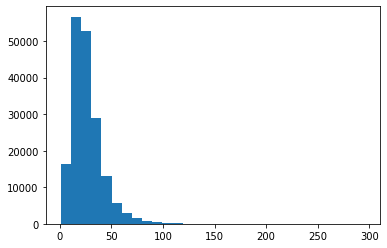

In [28]:
plt.hist(sent_lens,bins=30)

In [29]:
output_sequence_len = int(np.percentile(sent_lens,95))
print(output_sequence_len)


55


In [30]:
# unique_words = set(sum([i.split() for i in train_sentences],[]))
# print('total unique words',len(unique_words))

In [31]:
vocab_size = 68000 # from the research paper.

#text vectorixzation layer
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(max_tokens=vocab_size,output_mode='int', standardize='lower_and_strip_punctuation',output_sequence_length=output_sequence_len ) 

In [32]:
text_vectorization.adapt(train_sentences)

In [33]:
train_vocab = text_vectorization.get_vocabulary()
print("Vocab Size: ",len(train_vocab))
print("20 Most Occuring words",train_vocab[:20])
print('20 least occuring words',train_vocab[-20:])

Vocab Size:  64841
20 Most Occuring words ['', '[UNK]', 'the', 'and', 'of', 'in', 'to', 'with', 'a', 'were', 'was', 'for', 'patients', 'group', 'p', 'at', 'or', 'study', 'on', 'treatment']
20 least occuring words ['abandon', 'abaloparatideinduced', 'abagovomabinduced', 'abacus', 'abacopd', 'abacavirlamivudinezidovudine', 'ababa', 'aavsercaa', 'aats', 'aartselaar', 'aarm', 'aaqol', 'aaq', 'aanhui', 'aana', 'aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
#embedding layer
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size,output_dim = 128,input_length=output_sequence_len)


In [35]:
#architecture= preprocessing, textvectorization, embeeding layer(output will be (batch,len, embedding)), global average pooling to get sentence feature, than dense model

input_layer = tf.keras.layers.Input(shape=(1,),dtype='string')
text_vector = text_vectorization(input_layer)
embedding_output = embedding_layer(text_vector)
x = tf.keras.layers.Conv1D(filters=64,kernel_size=5,padding='same',activation='relu')(embedding_output)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes,activation='softmax')(x)



model_1 = tf.keras.Model(input_layer,outputs)

model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [36]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [37]:
# creating datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))

In [38]:
#looking at iterable dataset object
for sent,label in train_dataset:
  print(sent.shape,label.shape)
  print(sent,label)
  break

() (5,)
tf.Tensor(b'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .', shape=(), dtype=string) tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


In [39]:
#applying batch and prefetch transformations to our dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [40]:
import os
import datetime
def create_tensorboard_callback(log_dir,experiment_name):

  experiment_log_dir = os.path.join(log_dir,experiment_name,datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  callback = tf.keras.callbacks.TensorBoard(experiment_log_dir)
  print("Saving tensorboard logs at: ",experiment_log_dir)
  return callback

In [41]:
tf.keras.callbacks.TensorBoard

keras.callbacks.TensorBoard

In [42]:
#training model1

model_1.fit(train_dataset,
            epochs=5,
            steps_per_epoch = int(0.1 * len(train_dataset)),
            validation_data=val_dataset,
            validation_steps = int(0.1*len(val_dataset)),
            callbacks = [create_tensorboard_callback('/content/log_dir',"Model_1_Conv1D")]

            )

Saving tensorboard logs at:  /content/log_dir/Model_1_Conv1D/20220417-144156
Epoch 1/5
562/562 [==============================] - 15s 9ms/step - loss: 0.9078 - accuracy: 0.6427 - val_loss: 0.6796 - val_accuracy: 0.7387
Epoch 2/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6586 - accuracy: 0.7567 - val_loss: 0.6322 - val_accuracy: 0.7716
Epoch 3/5
562/562 [==============================] - 5s 9ms/step - loss: 0.6204 - accuracy: 0.7731 - val_loss: 0.5990 - val_accuracy: 0.7839
Epoch 4/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5909 - accuracy: 0.7875 - val_loss: 0.5798 - val_accuracy: 0.7856
Epoch 5/5
562/562 [==============================] - 5s 9ms/step - loss: 0.5902 - accuracy: 0.7924 - val_loss: 0.5615 - val_accuracy: 0.7989


In [43]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true,y_pred):
  """Function to calcualte classification metrics for given ground truth and predicted values
  Args:
    y_true: Ground Truth vector containing ground truth labels
    y_pred: Predicted value containing labels
  Returns:
    result: dict containing accuracy, recall, precision and f1-score
    """

  acc = accuracy_score(y_true,y_pred)
  model_precision, model_recall, model_f1_score,_ = precision_recall_fscore_support(y_true,y_pred,average='weighted')
  

  return {'accuracy':acc,'recall':model_precision,'precision':model_precision,'f1-score':model_f1_score}

In [44]:
model_1_pred_prob = model_1.predict(test_sentences)

In [45]:
model_1_preds = tf.argmax(model_1_pred_prob,axis=1)
model_1_results = calculate_results(test_labels_encoded,model_1_preds)

In [46]:
print(model_1_results)

{'accuracy': 0.795486975277916, 'recall': 0.794270682174887, 'precision': 0.794270682174887, 'f1-score': 0.7923619895785801}


In [47]:
#evaluate the model on entire val dataset
print(model_1.evaluate(val_dataset))

945/945 [==============================] - 3s 3ms/step - loss: 0.5606 - accuracy: 0.8007
[0.5606052279472351, 0.80074143409729]


## Model2 : tf hub universal sentence encoder


In [48]:
import tensorflow_hub as hub

embed = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",trainable=False,name='universal_sent_encoder_embedding')

In [49]:
type(embed)

tensorflow_hub.keras_layer.KerasLayer

In [50]:
import random
#visualingin embed output
random_sentence = random.choice(train_sentences)
embed_output = embed([random_sentence])
print("sentence: ",random_sentence)
print("Embed Output shape: ",embed_output.shape)

sentence:  Asthma is often poorly controlled .
Embed Output shape:  (1, 512)


In [51]:
#creating the model

input_layer = tf.keras.layers.Input(shape=[],name='Input_Layer',dtype='string')
embed_output = embed(input_layer)
x = tf.keras.layers.Dense(128,activation='relu')(embed_output)
output_layer = tf.keras.layers.Dense(num_classes,activation='softmax',name='output_dense_layer')(x)

model_2 = tf.keras.Model(input_layer,output_layer)

In [52]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_Layer (InputLayer)    [(None,)]                 0         
                                                                 
 universal_sent_encoder_embe  (None, 512)              256797824 
 dding (KerasLayer)                                              
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 output_dense_layer (Dense)  (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [53]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [54]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1*len(train_dataset)),
            epochs = 5,
            validation_data=val_dataset,
            validation_steps = int(0.1*len(val_dataset)),
            callbacks = [create_tensorboard_callback("/content/log_dir","Model_2_USE")])

Saving tensorboard logs at:  /content/log_dir/Model_2_USE/20220417-144258
Epoch 1/5
562/562 [==============================] - 10s 13ms/step - loss: 0.9172 - accuracy: 0.6512 - val_loss: 0.7957 - val_accuracy: 0.6898
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7678 - accuracy: 0.7020 - val_loss: 0.7523 - val_accuracy: 0.7068
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7508 - accuracy: 0.7126 - val_loss: 0.7363 - val_accuracy: 0.7118
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7169 - accuracy: 0.7248 - val_loss: 0.7091 - val_accuracy: 0.7320
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7257 - accuracy: 0.7213 - val_loss: 0.6895 - val_accuracy: 0.7350


In [55]:
#model 2 evaluation
model_2.evaluate(val_dataset)

945/945 [==============================] - 10s 10ms/step - loss: 0.6986 - accuracy: 0.7346


[0.6986215114593506, 0.7346418499946594]

In [56]:
#model2 results
model_2_pred_probs = model_2.predict(test_sentences)
model_2_preds = tf.argmax(model_2_pred_probs,axis=1)
model_2_results = calculate_results(model_2_preds,test_labels_encoded)


In [57]:
print(model_2_results)

{'accuracy': 0.7267960842873735, 'recall': 0.7445109334992009, 'precision': 0.7445109334992009, 'f1-score': 0.7322399030091866}


## Model 3: Conv1D with character level embeddings
In word level embeddings we represent "words" with numerical vectors, but in character level embedding each "character" of the "word" gets converted into numerical vectors.
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ex. [i love tensorflow] -> [feature vector of every word]
[l l o v e t e n s o r f l o w] -> [feature vector of every character]

In [58]:
def split_chars(text):

  return " ".join(list(text))

split_chars(random_sentence)

'A s t h m a   i s   o f t e n   p o o r l y   c o n t r o l l e d   .'

In [59]:
train_chars = [split_chars(sent) for sent in train_sentences]
test_chars = [split_chars(sent) for sent in test_sentences]
val_chars = [split_chars(sent) for sent in val_sentences]


In [60]:
len_chars = [len(sent) for sent in train_sentences]
print("Mean len chars: ",np.mean(len_chars))

Mean len chars:  149.3662574983337


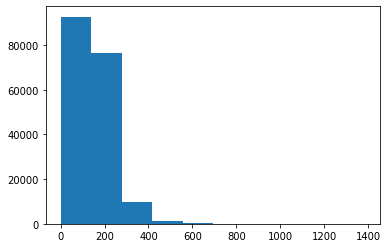

In [61]:
#distribution of our sequence at char level
import matplotlib.pyplot as plt
plt.hist(len_chars,bins=10);

In [62]:
output_seq_char_len = np.percentile(len_chars,95)
print('95th percentile of char len',output_seq_char_len)

95th percentile of char len 290.0


In [63]:
#total unique characters in our vocab
# path1 - find all unique chars in our train sentences
# path2 - all possible characters in eng language (all the ones present on keyboard

import string
char_vocab = string.ascii_lowercase + string.digits + string.punctuation
NUM_CHAR_TOKENS = len(char_vocab) + 2 # adding 2 for " " and "UNK" (space and OOV or unknown tokens)


In [64]:
char_tokenizer = tf.keras.layers.TextVectorization(max_tokens=NUM_CHAR_TOKENS,

 output_sequence_length=int(output_seq_char_len))

In [65]:
char_tokenizer.adapt(train_chars)

In [66]:
random_char = random.choice(train_chars)
print(random_char)
print(char_tokenizer([random_char]))

I n   t h i s   p i l o t   s t u d y   ,   t h e r e   w a s   s u f f i c i e n t   e v i d e n c e   t h a t   s t i m u l a n t s   m a y   b e   u s e f u l   i n   m a n a g e m e n t   o f   b e h a v i o r a l   a n d   c o g n i t i v e   s e q u e l a e   f o l l o w i n g   T B I   ,   t o   w a r r a n t   a   l a r g e r   t r i a l   .
tf.Tensor(
[[ 4  6  3 13  4  9 14  4 12  7  3  9  3 16 10 19  3 13  2  8  2 20  5  9
   9 16 17 17  4 11  4  2  6  3  2 21  4 10  2  6 11  2  3 13  5  3  9  3
   4 15 16 12  5  6  3  9 15  5 19 22  2 16  9  2 17 16 12  4  6 15  5  6
   5 18  2 15  2  6  3  7 17 22  2 13  5 21  4  7  8  5 12  5  6 10 11  7
  18  6  4  3  4 21  2  9  2 26 16  2 12  5  2 17  7 12 12  7 20  4  6 18
   3 22  4  3  7 20  5  8  8  5  6  3  5 12  5  8 18  2  8  3  8  4  5 12
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [67]:
char_vocab = char_tokenizer.get_vocabulary()
print("Char vocab size: ",len(char_vocab))

Char vocab size:  28


In [68]:
#making character level embedding
char_embed = tf.keras.layers.Embedding(input_dim = len(char_vocab), output_dim=25, #got this number from rct paper
                                 input_length = output_seq_char_len, name='char_embed',mask_zero=True        )

In [69]:
random_char_sent = random.choice(train_chars)
print("Origin char level sent",random_char_sent,sep="\n")
tokenized_char_sent = char_tokenizer([random_char_sent])
print("Sent after tokenization: ",tokenized_char_sent,"Shape: ",tokenized_char_sent.shape,sep='\n')
embed_char_sent = char_embed(tokenized_char_sent)
print("Embed Output: ",embed_char_sent,'Embed OUput shape: ',embed_char_sent.shape)

Origin char level sent
S u b j e c t s   a l s o   s h o w e d   g r e a t e r   i m p a i r m e n t   w h e n   s c o r e s   o b t a i n e d   i n   t h e   @ , @ - f t   c o n d i t i o n   w e r e   c o m p a r e d   t o   b a s e l i n e   ,   a l t h o u g h   t h e   e f f e c t s   w e r e   n o t   a s   c l e a r l y   d e f i n e d   r e l a t i v e   t o   t h e   @ , @   v s .   b a s e l i n e   c o n t r a s t s   .
Sent after tokenization: 
tf.Tensor(
[[ 9 16 22 27  2 11  3  9  5 12  9  7  9 13  7 20  2 10 18  8  2  5  3  2
   8  4 15 14  5  4  8 15  2  6  3 20 13  2  6  9 11  7  8  2  9  7 22  3
   5  4  6  2 10  4  6  3 13  2 17  3 11  7  6 10  4  3  4  7  6 20  2  8
   2 11  7 15 14  5  8  2 10  3  7 22  5  9  2 12  4  6  2  5 12  3 13  7
  16 18 13  3 13  2  2 17 17  2 11  3  9 20  2  8  2  6  7  3  5  9 11 12
   2  5  8 12 19 10  2 17  4  6  2 10  8  2 12  5  3  4 21  2  3  7  3 13
   2 21  9 22  5  9  2 12  4  6  2 11  7  6  3  8  5  9  3  9  0  0  0  0
   0  0  0

In [70]:
#we need to create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [71]:
#model3 

input_layer = tf.keras.layers.Input(shape=(1,),dtype='string')
char_token_output = char_tokenizer(input_layer)
char_embed_output = char_embed(char_token_output)
conv_layer = tf.keras.layers.Conv1D(64,kernel_size=3,activation='relu',padding='same')(char_embed_output)
pooling_output = tf.keras.layers.GlobalAveragePooling1D()(conv_layer)
#fc layers
x = tf.keras.layers.Dense(128,activation='relu')(pooling_output)
output_layer = tf.keras.layers.Dense(num_classes,activation='softmax',name='output_layer')(x)


model_3 = tf.keras.Model(input_layer,output_layer)

#compiling the model
model_3.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['acc'])

In [72]:
model_3_history = model_3.fit(train_char_dataset,
                              epochs=5,
                              steps_per_epoch = int(len(train_char_dataset)),
                              validation_data=(val_char_dataset),
                              validation_steps=int(0.1*len(val_char_dataset)),
                              callbacks=[create_tensorboard_callback("/content/log_dir","conv1d_with_char_level_embed")])

Saving tensorboard logs at:  /content/log_dir/conv1d_with_char_level_embed/20220417-144425
Epoch 1/5
5627/5627 [==============================] - 29s 5ms/step - loss: 1.2821 - acc: 0.4572 - val_loss: 1.1886 - val_acc: 0.4977
Epoch 2/5
5627/5627 [==============================] - 28s 5ms/step - loss: 1.0998 - acc: 0.5460 - val_loss: 1.0326 - val_acc: 0.5645
Epoch 3/5
5627/5627 [==============================] - 27s 5ms/step - loss: 0.9994 - acc: 0.5887 - val_loss: 0.9479 - val_acc: 0.5981
Epoch 4/5
5627/5627 [==============================] - 27s 5ms/step - loss: 0.9383 - acc: 0.6165 - val_loss: 0.8917 - val_acc: 0.6356
Epoch 5/5
5627/5627 [==============================] - 27s 5ms/step - loss: 0.8968 - acc: 0.6366 - val_loss: 0.8581 - val_acc: 0.6536


In [73]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           4864      
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               8320

In [142]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs,axis=1)
model_3_results = calculate_results(model_3_preds,val_labels_encoded)
print(model_3_results)

{'accuracy': 0.6521911823116643, 'recall': 0.6759842999787747, 'precision': 0.6759842999787747, 'f1-score': 0.6612975582807396}


## Model4: Token embedding(USE) + character level embeddings
Steps:
1. Create a token level embedding using USE
2. charcter level embedding 
3. combine both of the output using concatenate layers



In [74]:
import tensorflow_hub as tfhub

In [75]:
word_embedding_layer = tfhub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',trainable=False,name='USE_layer')

In [76]:
#making character level embedding
char_embed = tf.keras.layers.Embedding(input_dim = len(char_vocab), output_dim=25, #got this number from rct paper
                                 input_length = output_seq_char_len, name='char_embed',mask_zero=True        )

In [77]:
#step1
#word level embedding model

word_input_layer = tf.keras.layers.Input(shape=[],dtype='string')
# text_vector_output = text_vectorization(word_input_layer)
word_embedding_output = word_embedding_layer(word_input_layer)
token_output = tf.keras.layers.Dense(128,activation='relu')(word_embedding_output)
token_model = tf.keras.Model(word_input_layer,token_output)



#step2

char_input = tf.keras.layers.Input(shape=[],dtype='string',name='char_input')
char_vectors = char_tokenizer(char_input)
char_embedding_output = char_embed(char_vectors)
lstm_layer = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embedding_output)
char_model = tf.keras.Model(inputs=char_input,outputs=lstm_layer)


#concatenate token and char inputs(create hybrid token embeddings)
token_char_concat = tf.keras.layers.Concatenate(name='token_char_hybrid_layer')([token_model.output,char_model.output])
# print(token_char_concat.shape)

#dense layers with Dropouts as per paper
combined_dropout = tf.keras.layers.Dropout(0.5)(token_char_concat)
combined_dense = tf.keras.layers.Dense(200,activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.5)(combined_dense)
final_dense = tf.keras.layers.Dense(num_classes,activation='softmax')(final_dropout)

#final output
model_4 = tf.keras.Model(inputs= [word_input_layer,char_input],outputs=final_dense)

In [78]:
model_4.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_input[0][0]']             
 orization)                                                                                       
                                                                                                  
 USE_layer (KerasLayer)         (None, 512)          256797824   ['input_3[0][0]']          

In [79]:
#checking the output of token model given a test sent.
print("token model output")
print(token_model(tf.constant(['this is a test sentence'])))

print('char model output')
print(char_model(tf.constant(['this is a test sentence'])))

token model output
tf.Tensor(
[[0.00000000e+00 4.52137887e-02 0.00000000e+00 6.98595718e-02
  5.16295619e-02 1.33198619e-01 2.66589988e-02 0.00000000e+00
  0.00000000e+00 4.22778539e-02 8.92750993e-02 6.40697107e-02
  0.00000000e+00 3.68347391e-02 0.00000000e+00 1.48248747e-02
  0.00000000e+00 0.00000000e+00 7.51909390e-02 4.29242030e-02
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.45116409e-02
  0.00000000e+00 0.00000000e+00 8.31265561e-03 0.00000000e+00
  0.00000000e+00 3.16205099e-02 6.24189116e-02 0.00000000e+00
  1.74454472e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 6.92351758e-02
  0.00000000e+00 0.00000000e+00 1.04350969e-02 1.44911721e-01
  1.60074860e-01 1.44592505e-02 0.00000000e+00 4.23864685e-02
  0.00000000e+00 0.00000000e+00 3.94625589e-02 0.00000000e+00
  8.34271405e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 4.368311

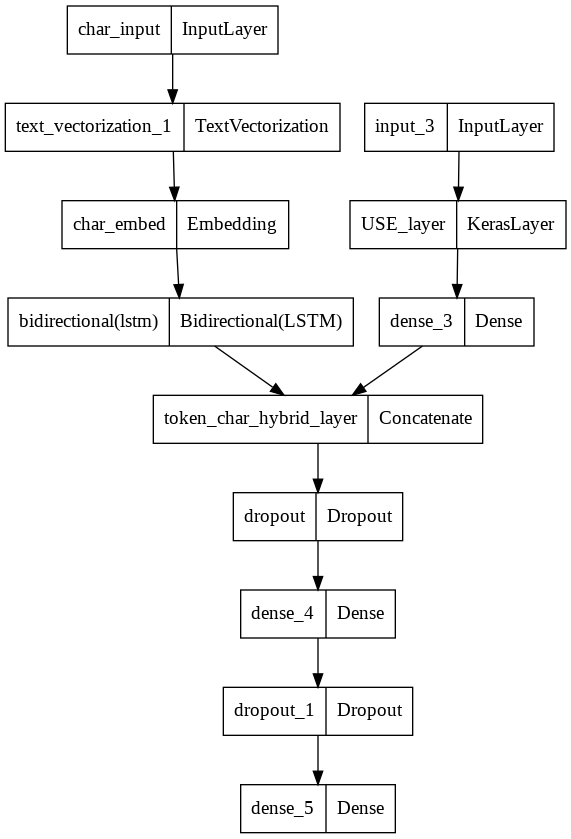

In [80]:
#plot the model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [81]:
model_4.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['acc'])

In [82]:
#creating token and char dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices(((train_sentences,train_chars),train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_token_data = tf.data.Dataset.from_tensor_slices(((test_sentences,test_chars),test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_token_data = tf.data.Dataset.from_tensor_slices(((val_sentences,val_chars),val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [83]:
model_4_history = model_4.fit(train_char_token_data,
                              epochs=5,
                              steps_per_epoch = int(0.1*len(train_char_token_data)),
                              validation_data = val_char_token_data,
                              validation_steps=int(0.1*len(val_char_token_data)),
                              callbacks=[create_tensorboard_callback('/content/log_dir','model_4_word_char_hybrid_embedding')])

Saving tensorboard logs at:  /content/log_dir/model_4_word_char_hybrid_embedding/20220417-144720
Epoch 1/5
562/562 [==============================] - 40s 54ms/step - loss: 0.9688 - acc: 0.6157 - val_loss: 0.7721 - val_acc: 0.7028
Epoch 2/5
562/562 [==============================] - 27s 49ms/step - loss: 0.7907 - acc: 0.6919 - val_loss: 0.7171 - val_acc: 0.7221
Epoch 3/5
562/562 [==============================] - 26s 46ms/step - loss: 0.7702 - acc: 0.7033 - val_loss: 0.6913 - val_acc: 0.7384
Epoch 4/5
562/562 [==============================] - 29s 52ms/step - loss: 0.7391 - acc: 0.7201 - val_loss: 0.6673 - val_acc: 0.7543
Epoch 5/5
562/562 [==============================] - 27s 49ms/step - loss: 0.7470 - acc: 0.7150 - val_loss: 0.6603 - val_acc: 0.7517


In [84]:
model_4.evaluate(val_char_token_data)

945/945 [==============================] - 37s 39ms/step - loss: 0.6686 - acc: 0.7466


[0.6685634255409241, 0.7465907335281372]

In [87]:
model_4_pred_probs = model_4.predict(val_char_token_data)
model_4_preds = tf.argmax(model_4_pred_probs,axis=1)


In [88]:
 
model_4_results = calculate_results(model_4_preds,val_labels_encoded)
print(model_4_results)

{'accuracy': 0.7465907586389514, 'recall': 0.7640561739797183, 'precision': 0.7640561739797183, 'f1-score': 0.7519181890659857}


## Model5: Token Emedding + Char Embedding + Positional Embedding

In [89]:
#using that line number and their order hold some knowledge which can be converted into numbers and used while models
train_df.head()

,line_number,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11


In [90]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

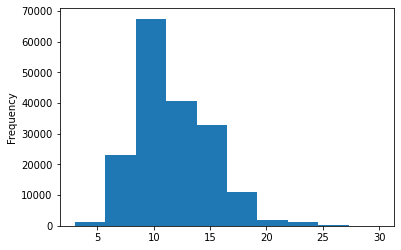

In [93]:
#checking the distribution of total lines numbers
train_df['total_lines'].plot.hist();

In [97]:
#finding total lines which covers 98 percent of data
total_lines_depth = np.percentile(train_df['total_lines'],98)
print(total_lines_depth)

20.0


In [98]:
# we can encode total lines feature as one hot encoded feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'],depth=total_lines_depth)
train_total_lines_one_hot[:10]

<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
     

In [99]:
#engineered features should be available at test time also.
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'],depth=total_lines_depth)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'],depth=total_lines_depth)

In [100]:
#looking at line number feature
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

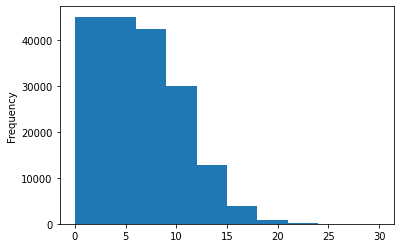

In [102]:
#looks like most examples go up to 15 number of lines.
train_df['line_number'].plot.hist();

In [103]:
line_number_depth = np.percentile(train_df['line_number'],98)
print(line_number_depth)

15.0


In [129]:
train_line_number_one_hot = tf.one_hot(train_df['line_number'],depth=line_number_depth)
test_line_number_one_hot = tf.one_hot(test_df['line_number'],depth=line_number_depth)
val_line_number_one_hot = tf.one_hot(val_df['line_number'],depth=line_number_depth)

### model5 steps
1. Word level embedding model
2. char level embedding model
3. line number model
4. total lines model
5. concatente 1 and 2
6. concatenate 3,4,5 into a token-character-positional tribred embedding.
7. create ouput model to accept tribred embedding
8. combine inputs for 1,2,3,4 and outputs of 7 into a keras model


In [106]:
embed.name

'universal_sent_encoder_embedding'

In [109]:
#making character level embedding
char_embed = tf.keras.layers.Embedding(input_dim = len(char_vocab), output_dim=25, #got this number from rct paper
                                 input_length = output_seq_char_len, name='char_embed',mask_zero=True        )

In [116]:
# 1. word level model
word_input_layer = tf.keras.layers.Input(shape=[],dtype='string',name='word_level_input')
word_embed_output = embed(word_input_layer) #this outputs feature vector of shape 512
word_vectors = tf.keras.layers.Dense(128,activation='relu',name='word_level_output')(word_embed_output)
token_model = tf.keras.Model(inputs=word_input_layer,outputs=word_vectors,name='word_level_model')

# 2. char level model
char_input_layer = tf.keras.layers.Input(shape=(1,),dtype='string',name='char_level_input')
char_vectorizer_output = char_tokenizer(char_input_layer)
char_embed_output = char_embed(char_vectorizer_output)
char_bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(25))(char_embed_output)
char_model = tf.keras.Model(char_input_layer,char_bi_lstm,name='char_level_model')

#3. line numbers
line_number_input = tf.keras.layers.Input(shape=(int(line_number_depth),),dtype=tf.int32,name='line_number_input')
x = tf.keras.layers.Dense(32,activation='relu')(line_number_input)
line_number_model = tf.keras.Model(line_number_input,x,name='line_number_model')

#4. total lines
total_lines_input = tf.keras.layers.Input(shape=(int(total_lines_depth),),dtype=tf.int32,name='total_lines_input')
y = tf.keras.layers.Dense(32,activation='relu')(total_lines_input)
total_lines_model = tf.keras.Model(total_lines_input,y,name='total_lines_model')

#5. concatenate 1 and 2
combined_embeddings = tf.keras.layers.Concatenate(name='token_char_hybrid_embedding')([token_model.output,char_model.output])
z = tf.keras.layers.Dense(256,activation='relu')(combined_embeddings)
z = tf.keras.layers.Dropout(0.5)(z)

#combining 3 4 and 5
z = tf.keras.layers.Concatenate(name='tribred_embedding')([line_number_model.output,total_lines_model.output,z])

output_layer = tf.keras.layers.Dense(num_classes,activation='softmax',name='final_output_layer')(z)

model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                  token_model.input,
                                 char_model.input],
                         outputs=output_layer)

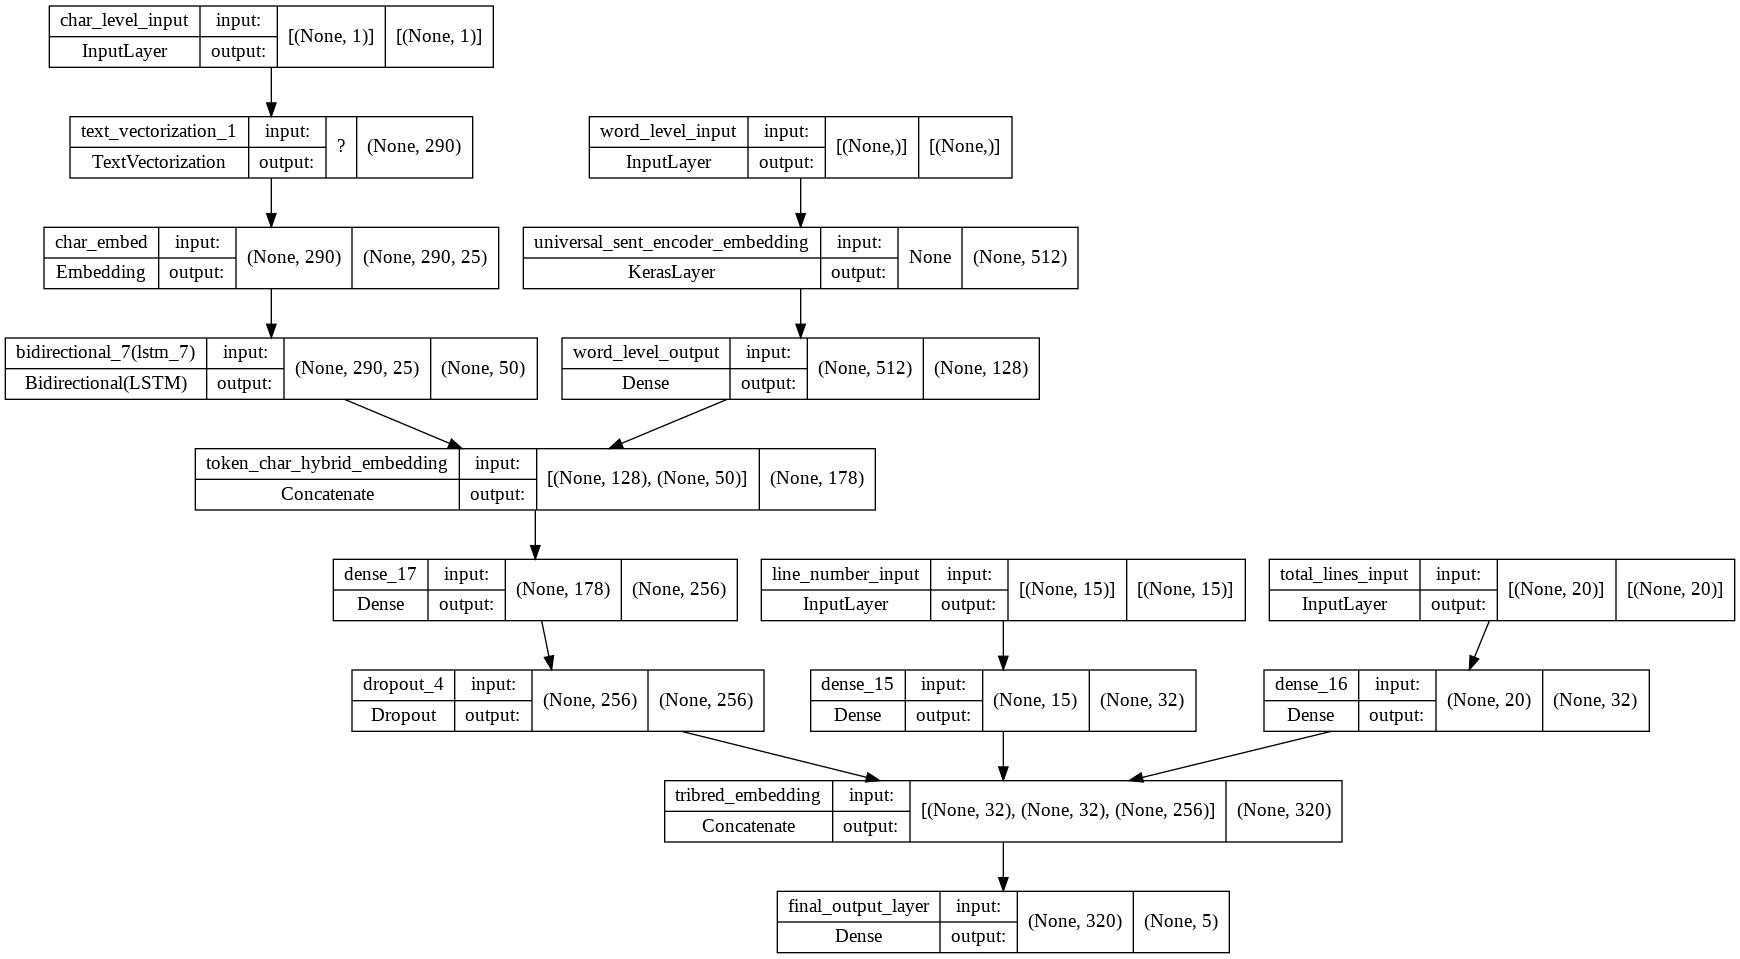

In [121]:
from tensorflow.keras.utils import plot_model
plot_model(model_5,show_shapes=True)

In [130]:
#preparing the dataset
train_tribred_data = tf.data.Dataset.from_tensor_slices(((train_line_number_one_hot,train_total_lines_one_hot,train_sentences,train_chars),train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_tribred_data = tf.data.Dataset.from_tensor_slices(((val_line_number_one_hot,val_total_lines_one_hot,val_sentences,val_chars),val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [131]:

model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['acc'])

In [132]:
model_5_history = model_5.fit(train_tribred_data,
                              epochs=5,
                              steps_per_epoch=int(0.1*len(train_tribred_data)),
                              validation_data=val_tribred_data,
                              validation_steps=int(0.1*len(val_tribred_data)),
                              callbacks=[create_tensorboard_callback('/content/log_dir','tribred_model')])

Saving tensorboard logs at:  /content/log_dir/tribred_model/20220417-161326
Epoch 1/5
562/562 [==============================] - 93s 97ms/step - loss: 0.4577 - acc: 0.8237 - val_loss: 0.4386 - val_acc: 0.8288
Epoch 2/5
562/562 [==============================] - 47s 85ms/step - loss: 0.4150 - acc: 0.8430 - val_loss: 0.4170 - val_acc: 0.8447
Epoch 3/5
562/562 [==============================] - 42s 74ms/step - loss: 0.4092 - acc: 0.8429 - val_loss: 0.4124 - val_acc: 0.8414
Epoch 4/5
562/562 [==============================] - 51s 91ms/step - loss: 0.4189 - acc: 0.8426 - val_loss: 0.3963 - val_acc: 0.8487
Epoch 5/5
562/562 [==============================] - 28s 49ms/step - loss: 0.4088 - acc: 0.8446 - val_loss: 0.3907 - val_acc: 0.8527


In [133]:
model_5.evaluate(val_tribred_data)

945/945 [==============================] - 36s 38ms/step - loss: 0.3902 - acc: 0.8523


[0.39020636677742004, 0.8523434400558472]

In [134]:
model_5_pred_probs = model_5.predict(val_tribred_data)
model_5_preds = tf.argmax(model_5_pred_probs,axis=1)
model_5_results = calculate_results(model_5_preds,val_labels_encoded)
print(model_5_results)

{'accuracy': 0.8523434396928373, 'recall': 0.8674797644276956, 'precision': 0.8674797644276956, 'f1-score': 0.8560151903136927}


## Comparing different model results


In [152]:
import pandas as pd
results_df = pd.DataFrame({
    "Mode_0_baseline":model_0_results,
    "Mode_1_custom_token_embedding":model_1_results,
    "Model_2_Pretrained_Token_embedding":model_2_results,
    "Model_3_Custom_Char_EMbedding":model_3_results,
    "Model_4_Hybrid_Char+Token_EMbedding":model_4_results,
    "Model_5_Char+Token+Position_Tribred_Embedding":model_5_results
}).transpose()

In [154]:

results_df.fillna(0,inplace=True)

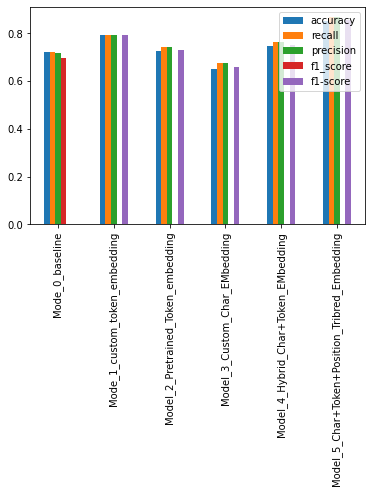

In [156]:
results_df.plot(kind='bar',figsize=(10,7));